# Cadeias de Algoritmos e Pipelines

Como vimos nos capítulos passados, alguns problemas requerem um conjunto de passos de processamento antes do uso do modelo. A maioria dos modelos lineares se beneficiam muito de escalonamento e criação de interações polinomiais - e esses passos devem ser aplicados a quase todos os datasets reais.

Nesse capítulo, iremos aprender como utilizar a classe `Pipeline` do scikit-learn para simplificar o processo de construir combinações de transformações, processamento e o modelo. Além disso, iremos aprender a utilizar o `Pipeline` em conjunto com o `GridSearchCV` para procurar por parâmetros em todos os passos de processamento de uma só vez.

Vamos começar com um exemplo inicial utilizando o SVM no dataset de câncer de mama:

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# separando os dados
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, random_state=0) 

# aplicando o escalonamento
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instanciar e utilizar o modelo
svm = SVC().fit(X_train_scaled, y_train)

print(svm.score(X_test_scaled, y_test))

0.972027972027972


## Selecionando Parametros c/ Preprocessamento

Com o modelo "baseline" treinado, podemos ir atrás de hiperparâmetros melhores, como vimos no último capítulo. Uma forma ingênua de se fazer isso seria assim:

In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"Melhor acurácia na CV: {grid.best_score_:.6f}")
print(f"Melhor acurácia no Test: {grid.score(X_test_scaled, y_test):.6f}")
print("Melhores hiperparâmetros: ", grid.best_params_)

Melhor acurácia na CV: 0.981231
Melhor acurácia no Test: 0.972028
Melhores hiperparâmetros:  {'C': 1, 'gamma': 1}


Sem um olhar atento, o código acima não parece ter erro algum. No entanto, note que a hiperparametrização é realizada através de CV - dividindo o set de treino em 5 partes, treinando em 4 e testando em 1. O set de treino foi escalonado previamente à validação cruzada, tornando o set de validação criado pela CV inválido - uma vez que ele foi utilizado para realizar o pré-processamento. 

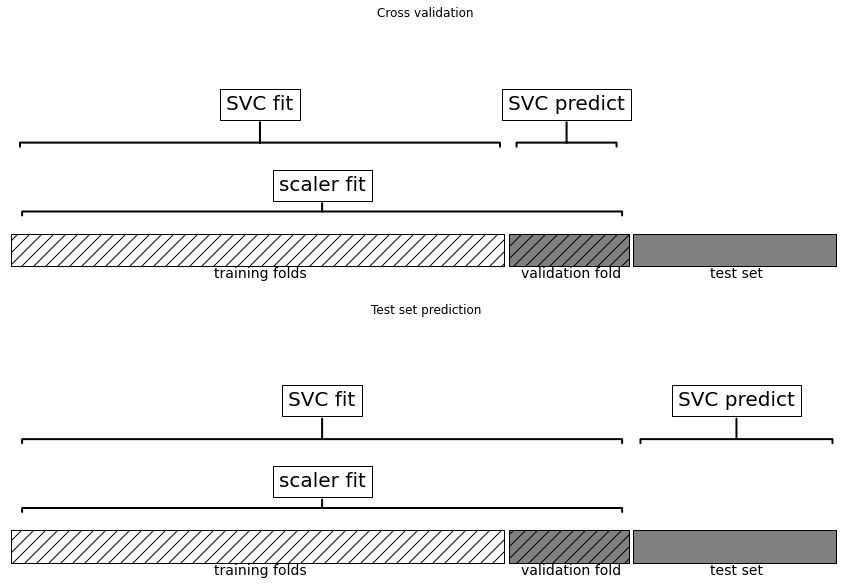

In [3]:
import mglearn

mglearn.plots.plot_improper_processing()

Para resolver isso, devemos aplicar o escalonamento (ou qualquer que seja o passo de pré-processamento) antes da separação do dataset, para que o vazamento de informação não aconteça - como discutimos no capítulo passado.

A classe que dá nome a esse capítulo, `Pipeline`, é a ferramenta que serve para resolução. Após instanciada, ela funciona quase como um qualquer outro modelo do scikit-learn, possuindo os métodos `fit`, `predict` e `score`. 

In [4]:
from sklearn.pipeline import Pipeline

pl = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC())
])

No snippet acima, temos uma pipeline com apenas 2 passos: o escalonamento utilizando o MinMaxScaler() e aqui sendo chamado de 'scaler' e o 'svm', uma instância do SVC(). Agora, podemos tratá-lo como qualquer outro modelo, ajustá-lo ao dataset de treino e realizar a previsão:

In [5]:
pl.fit(X_train, y_train)

pl.score(X_test, y_test)

0.972027972027972

Como esperado, o resultado é exatamente igual ao primeiro modelo que construímos nesse capítulo - porque é o mesmo modelo. O principal benefício de ter criado essa pipeline é que agora podemos utiliza-la como um estimador para a validação cruzada ou para o `GridSearchCV`.

Para fazer isso, precisamos alterar apenas uma coisinha no `param_grid`. As keys do dicionário devem ser alteradas, recebendo o nome do estimador dentro da pipeline (no nosso caso, `'svm'`) como prefixo, separados com duas underscores.

In [6]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pl, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Melhor acurácia na CV: {grid.best_score_:.6f}")
print(f"Melhor acurácia no Test: {grid.score(X_test, y_test):.6f}")
print("Melhores hiperparâmetros: ", grid.best_params_)

Melhor acurácia na CV: 0.981231
Melhor acurácia no Test: 0.972028
Melhores hiperparâmetros:  {'svm__C': 1, 'svm__gamma': 1}


Apesar do resultado ter sido igual, o processo foi diferente. Dessa vez, não houve vazamentos de dados e podemos ter certeza que o nosso score e nossa previsão não estão sendo otimistas demais.

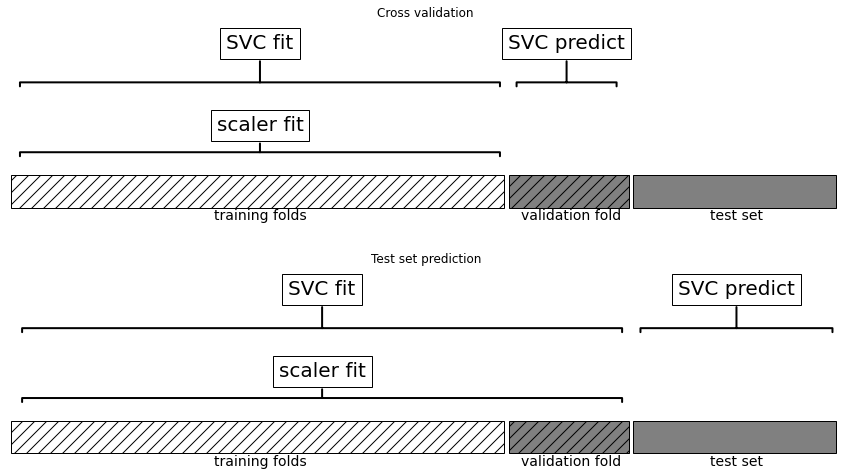

In [7]:
mglearn.plots.plot_proper_processing()

O escalonamento pode, mas no geral não vaza tanta informação assim ao modelo. Passos como seleção e extração de features, no entanto, podem causar impactos substanciais aos resultados.

## Acessando Atributos de cada um dos Passos

Caso haja necessidade de observar mais de perto algum dos passos realizados pela pipeline - seja os coeficientes do LinearRegression, os componentes extraídos pelo PCA, etc. - é possível acessar os passos utilizando o atributo `named_steps`, um dicionário:

In [8]:
pl.named_steps

{'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'svm': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False)}

Uma tarefa comum no uso de pipelines em conjunto com o `GridSearchCV` é acessar algum dos passos da pipeline dentro do GridSearch. Vamos criar uma pipeline nova, utilizando o StandardScaler e o LogisticRegression. 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pl = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

param_grid = {'lr__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
                cancer.data, cancer.target, random_state=42)

grid = GridSearchCV(pl, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                                           multi_class='auto',
             

Como vimos no quinto capítulo, o melhor modelo de um GridSearchCV é encontrado ao utilizar o atributo `.best_estimator_`. Quando utilizamos a pipeline, o atributo vai retornar a pipeline - no nosso caso, com os dois passos: 'scaler' e 'lr'. Podemos unir o `.best_estimator_` com o `named_steps` e dar uma olhada mais profunda no próprio modelo: 

In [10]:
print(f"LR step:\n{grid.best_estimator_.named_steps['lr']}")

print(f"Coeficientes do LR:\n{grid.best_estimator_.named_steps['lr'].coef_}")

LR step:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Coeficientes do LR:
[[ 0.01559634 -0.19828172  0.23505534 -0.27390037 -0.39359893  2.94062805
  -1.31672318 -3.39000419  0.91262345 -1.02386013 -3.62153176  0.66292036
  -0.10576852 -2.19282102 -0.30469832  0.10258468  0.37125806 -1.47505149
   1.37682261  2.05968138 -1.73146187 -2.42802563  0.05138329 -1.93391932
  -0.10341889  0.65348111 -2.35762942 -0.61404887 -2.71493656 -0.38967079]]


## Utilizando o GridSearch para Parametrizar o Pré-Processamento

Utilizando o `GridSearchCV` em conjunto com o pipeline, podemos realizar a parametrização de passos relacionados ao pré-processamento. No capítulo 4, utilizamos features polinomiais para melhorar o score do Ridge. No entanto, testar os resultados de cada grau de interação polinomial pode ser cansativo, isso quando o uso na verdade não traz benefício algum ao modelo. 
<br>

Assim como os hiperparametros do modelo, a pipeline permite testar parametros para os outros passos dentro dela:

In [11]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

pl = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('reg', Ridge())
])

param_grid = {'poly__degree': [1, 2, 3],
              'reg__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pl, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train);

Como são apenas dois hiperparâmetros, vamos realizar um heatmap para ver como a união deles altera os resultados.

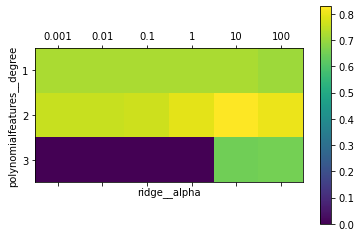

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
                 vmin=0, cmap="viridis")

fig.colorbar(cax)

plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")

plt.xticks(range(len(param_grid['reg__alpha'])), param_grid['reg__alpha'])
plt.yticks(range(len(param_grid['poly__degree'])),
param_grid['poly__degree'])

ax;

Note como adicionar 1 ou 2 graus de features polinomiais ajuda o modelo, mas o terceiro faz o score se aproximar de 0. Unir a parametrização do pré-processamento com a do modelo pode ser uma estratégia muito poderosa, mas muito custosa computacionalmente também. 

Por último, o uso de pipelines também permite inclusive o uso do `GridSearchCV` para decidir entre diferentes modelos. O processo é parecido com o que fizemos até agora, com a adição de outros modelos ao param_grid. Vale notar que isso torna o GridSearch ainda mais custoso e deve ser feito com cuidado.

In [15]:
from sklearn.ensemble import RandomForestClassifier

pl = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

param_grid = [{
    'clf': [SVC()], 'scaler': [StandardScaler(), None],
    'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'clf': [RandomForestClassifier(n_estimators=100)],
    'scaler': [None], 'clf__max_features': [1, 2, 3]}]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pl, param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Melhores Parâmetros:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.6f}")
print(f"Test-set score: {grid.score(X_test, y_test):.6f}")

Melhores Parâmetros:
{'clf': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'clf__C': 10, 'clf__gamma': 0.01, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.985882
Test-set score: 0.979021


## Sumário e Conclusão

O capítulo 6 introduziu a classe do scikit-learn chamada `pipeline`, uma ferramenta que ajuda a encadear algoritmos de pré-processamento e modelos. Essa classe é muito útil para a realização da validação-cruzada sem que haja vazamento de dados, da mesma forma que aumenta muito o potencial de hiperparametrizadores como o GridSearchCV. No entanto, as autoras não foram tão fundo no assunto e faltou mostrar como é realizada a criação de funções para pipeline utilizando o próprio scikit-learn, além do poderoso encapsulamento de pipelines. 

## Referência

**An Introduction to Machine Learning with Python** by Andreas C. Müller and Sarah Guido (O’Reilly), cap. 6. Copyright 2017 Sarah Guido and Andreas Müller, 978-1-449-36941-5.